<a href="https://colab.research.google.com/github/AnotherPianist/air-quality-forecasting/blob/main/air_quality_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Getting the data

In [2]:
import requests

url = "https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=xcl&macro=./RVII/709/Cal/PM25//PM25.horario.horario.ic&from=120707&to=211130&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath="
received_data = requests.get(url).content.decode()
splitted_data = [line.split(';') for line in received_data.split('\n')]
header_col, data = splitted_data[0], splitted_data[1:]
df = pd.DataFrame(data, columns=header_col)
df

,FECHA (YYMMDD),HORA (HHMM),Registros validados,Registros preliminares,Registros no validados,
0,120707,0100,,,,
1,120707,0200,,,,
2,120707,0300,,,,
3,120707,0400,,,,
4,120707,0500,,,,
...,...,...,...,...,...,...
82411,211130,2000,,7,,
82412,211130,2100,,7,,
82413,211130,2200,,11,,
82414,211130,2300,,7,,


# Preprocessing

## Empty column

There is a column without header and without values, let's drop it.

In [3]:
df.drop(columns='', inplace=True)
df

,FECHA (YYMMDD),HORA (HHMM),Registros validados,Registros preliminares,Registros no validados
0,120707,0100,,,
1,120707,0200,,,
2,120707,0300,,,
3,120707,0400,,,
4,120707,0500,,,
...,...,...,...,...,...
82411,211130,2000,,7,
82412,211130,2100,,7,
82413,211130,2200,,11,
82414,211130,2300,,7,


## Initial empty cells treatment

We see that the loaded DataFrame has empty cells.

In [4]:
df.isna().sum()

FECHA (YYMMDD)            0
HORA (HHMM)               1
Registros validados       1
Registros preliminares    1
Registros no validados    1
dtype: int64

Despite of clearly having empty cells in the DataFrame, pandas show us just the last row as missing values. Probably the other cells are filled with whitespaces, let's deal with that.

In [5]:
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)
df

,FECHA (YYMMDD),HORA (HHMM),Registros validados,Registros preliminares,Registros no validados
0,120707,0100,NaN,NaN,NaN
1,120707,0200,NaN,NaN,NaN
2,120707,0300,NaN,NaN,NaN
3,120707,0400,NaN,NaN,NaN
4,120707,0500,NaN,NaN,NaN
...,...,...,...,...,...
82411,211130,2000,NaN,7,NaN
82412,211130,2100,NaN,7,NaN
82413,211130,2200,NaN,11,NaN
82414,211130,2300,NaN,7,NaN


In [6]:
df.isna().sum()

FECHA (YYMMDD)                1
HORA (HHMM)                   1
Registros validados       24673
Registros preliminares    65932
Registros no validados    79673
dtype: int64

## Combining time related columns into timestamps

In [7]:
df['Date'] = pd.to_datetime(df['FECHA (YYMMDD)'] + df['HORA (HHMM)'], format="%y%m%d%H%M")
df

,FECHA (YYMMDD),HORA (HHMM),Registros validados,Registros preliminares,Registros no validados,Date
0,120707,0100,NaN,NaN,NaN,2012-07-07 01:00:00
1,120707,0200,NaN,NaN,NaN,2012-07-07 02:00:00
2,120707,0300,NaN,NaN,NaN,2012-07-07 03:00:00
3,120707,0400,NaN,NaN,NaN,2012-07-07 04:00:00
4,120707,0500,NaN,NaN,NaN,2012-07-07 05:00:00
...,...,...,...,...,...,...
82411,211130,2000,NaN,7,NaN,2021-11-30 20:00:00
82412,211130,2100,NaN,7,NaN,2021-11-30 21:00:00
82413,211130,2200,NaN,11,NaN,2021-11-30 22:00:00
82414,211130,2300,NaN,7,NaN,2021-11-30 23:00:00


In [8]:
df.drop(columns=['FECHA (YYMMDD)', 'HORA (HHMM)'], inplace=True)
df

,Registros validados,Registros preliminares,Registros no validados,Date
0,NaN,NaN,NaN,2012-07-07 01:00:00
1,NaN,NaN,NaN,2012-07-07 02:00:00
2,NaN,NaN,NaN,2012-07-07 03:00:00
3,NaN,NaN,NaN,2012-07-07 04:00:00
4,NaN,NaN,NaN,2012-07-07 05:00:00
...,...,...,...,...
82411,NaN,7,NaN,2021-11-30 20:00:00
82412,NaN,7,NaN,2021-11-30 21:00:00
82413,NaN,11,NaN,2021-11-30 22:00:00
82414,NaN,7,NaN,2021-11-30 23:00:00


## Numeric columns treatment

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82416 entries, 0 to 82415
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Registros validados     57743 non-null  object        
 1   Registros preliminares  16484 non-null  object        
 2   Registros no validados  2743 non-null   object        
 3   Date                    82415 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 2.5+ MB


In [10]:
df['Registros validados'] = pd.to_numeric(df['Registros validados'].str.replace(',', '.'))
df['Registros preliminares'] = pd.to_numeric(df['Registros preliminares'].str.replace(',', '.'))
df['Registros no validados'] = pd.to_numeric(df['Registros no validados'].str.replace(',', '.'))
df

,Registros validados,Registros preliminares,Registros no validados,Date
0,NaN,NaN,NaN,2012-07-07 01:00:00
1,NaN,NaN,NaN,2012-07-07 02:00:00
2,NaN,NaN,NaN,2012-07-07 03:00:00
3,NaN,NaN,NaN,2012-07-07 04:00:00
4,NaN,NaN,NaN,2012-07-07 05:00:00
...,...,...,...,...
82411,NaN,7.0,NaN,2021-11-30 20:00:00
82412,NaN,7.0,NaN,2021-11-30 21:00:00
82413,NaN,11.0,NaN,2021-11-30 22:00:00
82414,NaN,7.0,NaN,2021-11-30 23:00:00


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82416 entries, 0 to 82415
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Registros validados     57743 non-null  float64       
 1   Registros preliminares  16484 non-null  float64       
 2   Registros no validados  2743 non-null   float64       
 3   Date                    82415 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3)
memory usage: 2.5 MB


## PM records columns decision

In [12]:
df.isna().sum()

Registros validados       24673
Registros preliminares    65932
Registros no validados    79673
Date                          1
dtype: int64

We see that the column with less missing values is the one with validated records, so it's reasonable to think on using this column for building a model. Furthermore, as we know that this column is validated, it seems correct to use only this column to build a valid model.

However, as we want to maximize the use of existing data, we will combine the columns into one following these rules:
- If a value is available for the validated column, use this value.
- If a value is not available for the validated column, but there is a value in the preliminar column, use this one instead.
- If a value is not available neither in the validated nor the preliminar columns, use the value of the not validated column.
- If not record is available in any column, drop the record.

With these rules we reduce the number of records to be dropped, and we avoid the problem of imputing values that may not be related to its corresponding dates.

In [13]:
df['value'] = df['Registros validados']
df['value'].fillna(df['Registros preliminares'], inplace=True)
df['value'].fillna(df['Registros no validados'], inplace=True)

df.drop(columns=['Registros validados', 'Registros preliminares', 'Registros no validados'], inplace=True)

df.dropna(inplace=True)

df

,Date,value
15,2012-07-07 16:00:00,33.7100
16,2012-07-07 17:00:00,53.9500
17,2012-07-07 18:00:00,96.3999
18,2012-07-07 19:00:00,67.4298
19,2012-07-07 20:00:00,163.2000
...,...,...
82410,2021-11-30 19:00:00,3.0000
82411,2021-11-30 20:00:00,7.0000
82412,2021-11-30 21:00:00,7.0000
82413,2021-11-30 22:00:00,11.0000


# Visualize the data

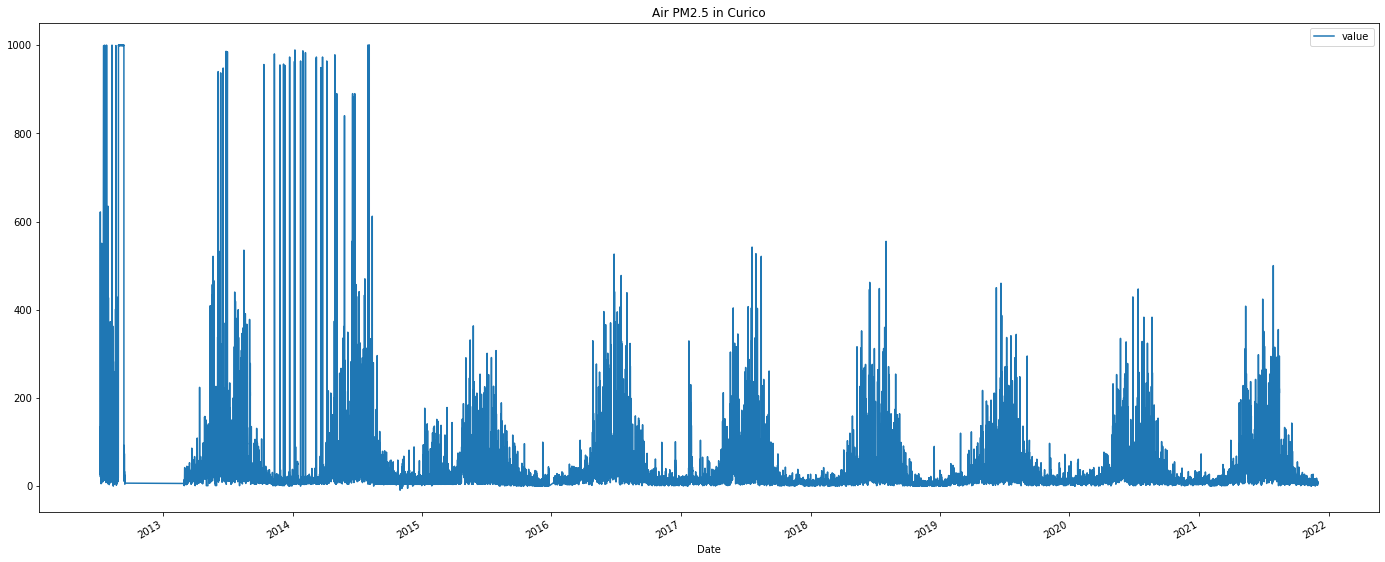

In [14]:
df.plot(x="Date", y='value', figsize=(24, 10), title="Air PM2.5 in Curico")

We can see that there are peaks of PM2.5 in the air around the mid of every year, coinciding with the winter months in Curico.

We can also see some weird records between 2012 and 2015 with random peaks reaching over 900. According to the U.S. Environmental Protection Agency, values over 500.4 are extremely hazardous, so it's probable that these records are incorrect records coming from defective capturing devices. We will treat these values as outliers and limit them to a maximum of 600.

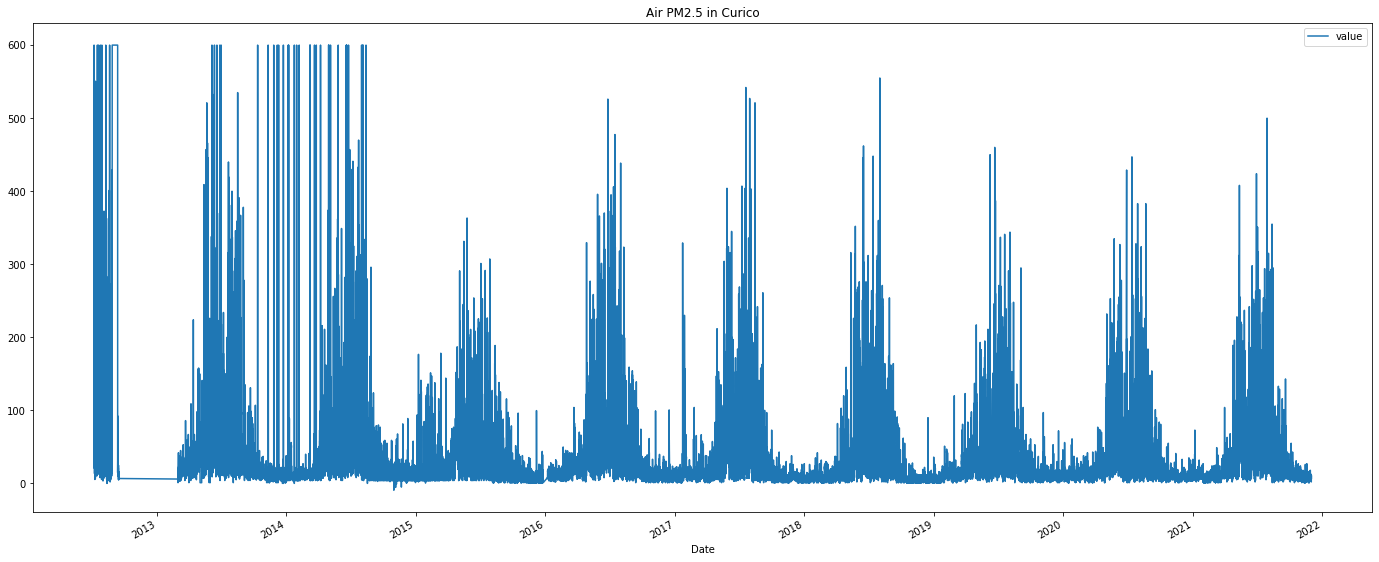

In [15]:
df['value'].clip(upper=600, inplace=True)

df.plot(x="Date", y='value', figsize=(24, 10), title="Air PM2.5 in Curico")

# Forecasting with Prophet

## Installing prophet

In [16]:
!pip install prophet

     |████████████████████████████████| 65 kB 2.7 MB/s 
     |████████████████████████████████| 49 kB 4.7 MB/s 
     |████████████████████████████████| 215 kB 18.4 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6640580 sha256=48393b4efaeaf69d3dd4a7386f8a540fbf2afc4bbb93dfbf4e4bfd29dc2f2a08
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [17]:
from prophet import Prophet

## Data requirement

Prophet requires data to be present in two columns named `ds` and `y`
- `ds` is the datestamp for the given record
- `y` is the value for the record

Let's name our dataset as required.

In [18]:
df.rename(columns={'Date': 'ds', 'value': 'y'}, inplace=True)

## Building the model

## Forecasting last two years

We will split the dataset so we will use the records up to December 31, 2019 as training data, and use the data for the last two years 2020 and 2021 as testing data.

### Splitting dataset

Since we have data starting from 2012, we want to make the test set from the last two years, so the testing size is around 0.2 of the whole dataset size.

In [19]:
train = df[df['ds'] <= '31-12-2019']
test = df[df['ds'] >= '01-01-2020']

In [20]:
train

,ds,y
15,2012-07-07 16:00:00,33.7100
16,2012-07-07 17:00:00,53.9500
17,2012-07-07 18:00:00,96.3999
18,2012-07-07 19:00:00,67.4298
19,2012-07-07 20:00:00,163.2000
...,...,...
65587,2019-12-30 20:00:00,9.0000
65588,2019-12-30 21:00:00,16.0000
65589,2019-12-30 22:00:00,27.0000
65590,2019-12-30 23:00:00,46.0000


In [21]:
test

,ds,y
65615,2020-01-01 00:00:00,21.0
65616,2020-01-01 01:00:00,19.0
65617,2020-01-01 02:00:00,21.0
65618,2020-01-01 03:00:00,17.0
65619,2020-01-01 04:00:00,12.0
...,...,...
82410,2021-11-30 19:00:00,3.0
82411,2021-11-30 20:00:00,7.0
82412,2021-11-30 21:00:00,7.0
82413,2021-11-30 22:00:00,11.0


In [22]:
# Calculate train and test percentages
print(f"Training size: {train.shape[0] / df.shape[0]}\nTesting set: {test.shape[0] / df.shape[0]}")

Training size: 0.7835130570352086
Testing set: 0.2161881252436014


### Model fitting

In [23]:
m = Prophet()
m.fit(train)

### Forecasting 2020-2021 air quality

In [24]:
future = m.make_future_dataframe(periods=365 * 2 * 24, freq='H')  # 365 days, two years, 24 records per day
future

,ds
0,2012-07-07 16:00:00
1,2012-07-07 17:00:00
2,2012-07-07 18:00:00
3,2012-07-07 19:00:00
4,2012-07-07 20:00:00
...,...
77822,2021-12-29 20:00:00
77823,2021-12-29 21:00:00
77824,2021-12-29 22:00:00
77825,2021-12-29 23:00:00


In [25]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2012-07-07 16:00:00,163.686013,95.234717,233.497472
1,2012-07-07 17:00:00,166.937605,94.660811,235.628408
2,2012-07-07 18:00:00,173.631006,104.434861,242.684103
3,2012-07-07 19:00:00,182.585757,114.716571,253.861092
4,2012-07-07 20:00:00,190.967995,127.531043,262.777951
...,...,...,...,...
77822,2021-12-29 20:00:00,25.130317,-82.056444,128.624040
77823,2021-12-29 21:00:00,30.215946,-78.892175,131.936122
77824,2021-12-29 22:00:00,30.610009,-74.447798,138.057491
77825,2021-12-29 23:00:00,27.193300,-75.676835,122.516820


### Visualizing forecast

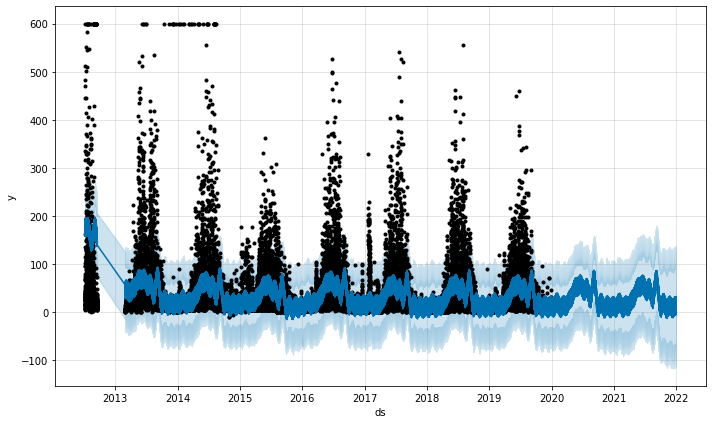

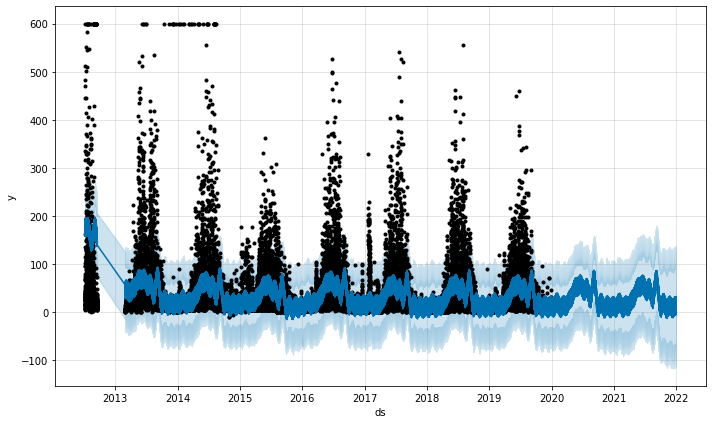

In [26]:
m.plot(forecast)

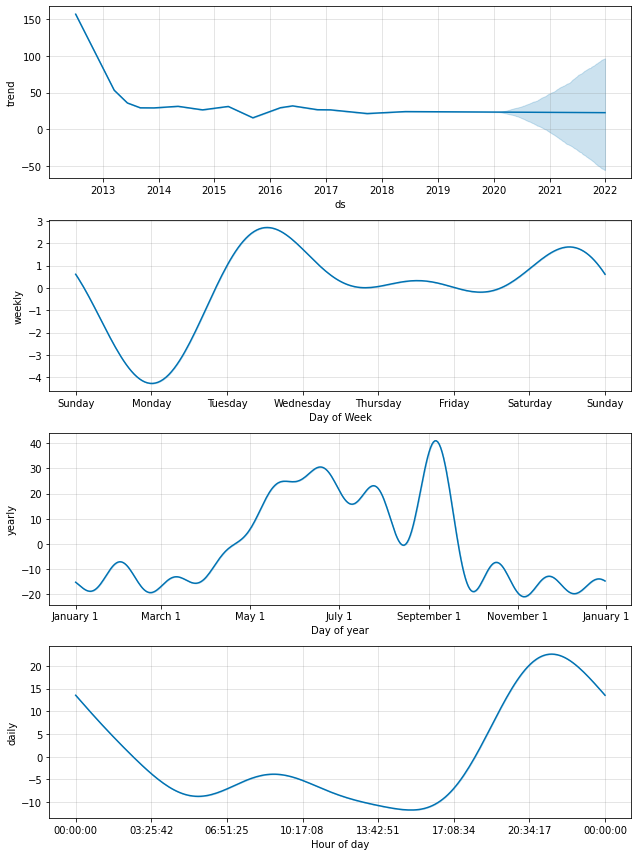

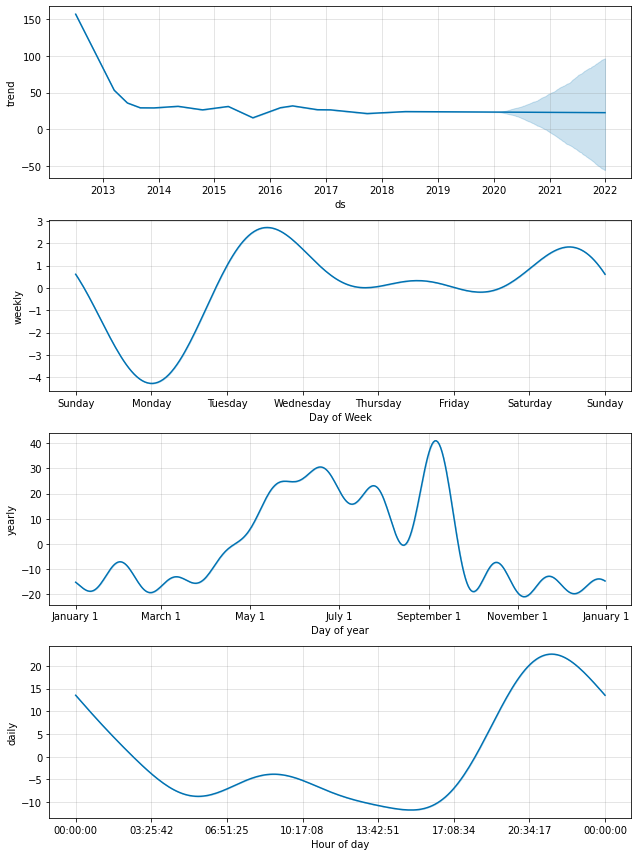

In [27]:
m.plot_components(forecast)

### Evaluating the forecast for the last two years

Firstly we will filter the forecasts to get only the records with dates that we can compare with the testing set.

In [28]:
test

,ds,y
65615,2020-01-01 00:00:00,21.0
65616,2020-01-01 01:00:00,19.0
65617,2020-01-01 02:00:00,21.0
65618,2020-01-01 03:00:00,17.0
65619,2020-01-01 04:00:00,12.0
...,...,...
82410,2021-11-30 19:00:00,3.0
82411,2021-11-30 20:00:00,7.0
82412,2021-11-30 21:00:00,7.0
82413,2021-11-30 22:00:00,11.0


In [29]:
forecast['ds']

0       2012-07-07 16:00:00
1       2012-07-07 17:00:00
2       2012-07-07 18:00:00
3       2012-07-07 19:00:00
4       2012-07-07 20:00:00
                ...        
77822   2021-12-29 20:00:00
77823   2021-12-29 21:00:00
77824   2021-12-29 22:00:00
77825   2021-12-29 23:00:00
77826   2021-12-30 00:00:00
Name: ds, Length: 77827, dtype: datetime64[ns]

Selecting the forecasted values that have a comparison entry in the testing set.

In [30]:
filtered_forecast = forecast[forecast.set_index('ds').index.isin(test.set_index('ds').index)]
filtered_forecast = filtered_forecast[['ds', 'yhat']]
filtered_forecast

,ds,yhat
60330,2020-01-01 00:00:00,23.929216
60331,2020-01-01 01:00:00,18.305691
60332,2020-01-01 02:00:00,13.013438
60333,2020-01-01 03:00:00,8.072516
60334,2020-01-01 04:00:00,3.855677
...,...,...
77125,2021-11-30 19:00:00,17.156241
77126,2021-11-30 20:00:00,25.566992
77127,2021-11-30 21:00:00,30.516764
77128,2021-11-30 22:00:00,30.760330


In [31]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

print(f"R2 (test): {r2_score(test['y'], filtered_forecast['yhat'])}")
print(f"MSE (test): {mean_squared_error(test['y'], filtered_forecast['yhat'])}")
print(f"MAE (test): {mean_absolute_error(test['y'], filtered_forecast['yhat'])}")
print(f"MAPE (test): {mean_absolute_percentage_error(test['y'], filtered_forecast['yhat'])}")

R2 (test): 0.20471314025319431
MSE (test): 986.0948902807586
MAE (test): 18.995788329150194
MAPE (test): 1.3783210435018252


## Whole dataset prediction

Now that we have predictions of the last two years, let's see what would the model say of the last two years when it's trained with that data.

In [32]:
m_future = Prophet()
m_future.fit(df)

In [33]:
df_forecast = m_future.predict(df)
df_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2012-07-07 16:00:00,166.088252,106.392903,231.676271
1,2012-07-07 17:00:00,169.080938,107.460237,224.609173
2,2012-07-07 18:00:00,175.428922,110.942168,235.166171
3,2012-07-07 19:00:00,184.068939,119.361014,242.849960
4,2012-07-07 20:00:00,192.285985,133.226302,251.624514
...,...,...,...,...
76965,2021-11-30 19:00:00,18.820288,-38.942627,80.327274
76966,2021-11-30 20:00:00,27.068642,-34.667073,91.362734
76967,2021-11-30 21:00:00,32.057050,-31.555135,96.824939
76968,2021-11-30 22:00:00,32.498262,-26.336540,98.832209


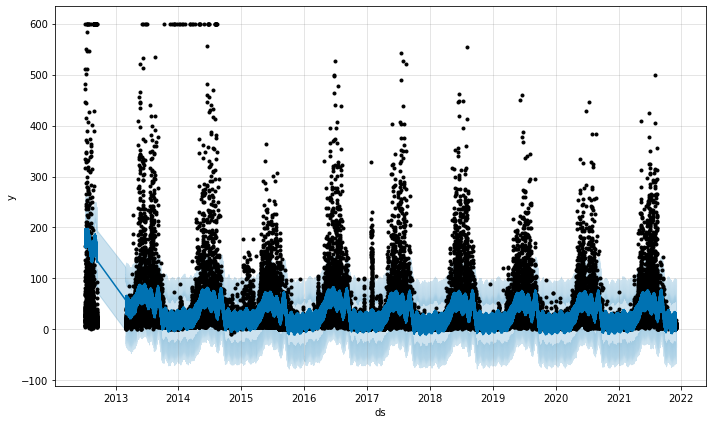

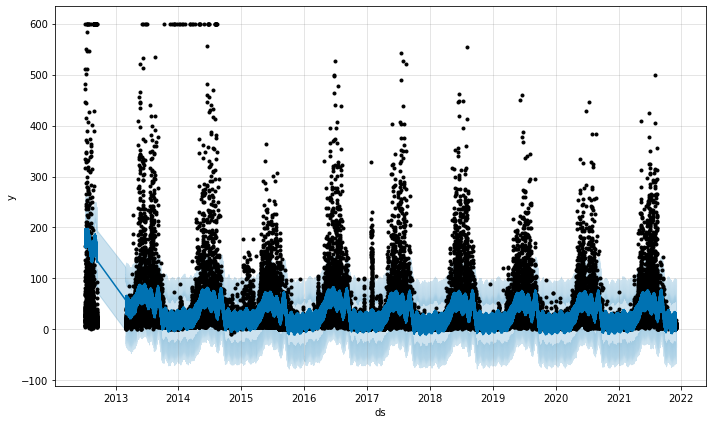

In [34]:
m_future.plot(df_forecast)

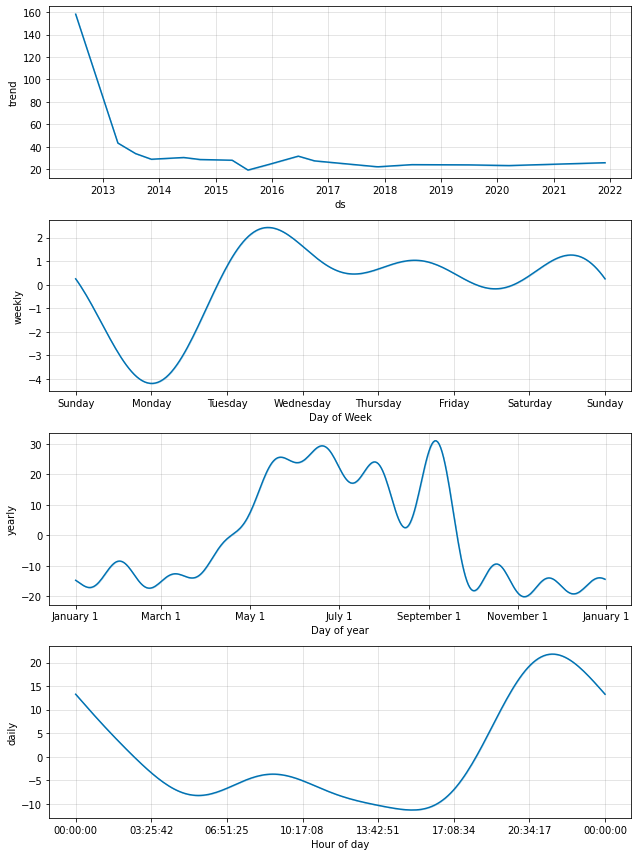

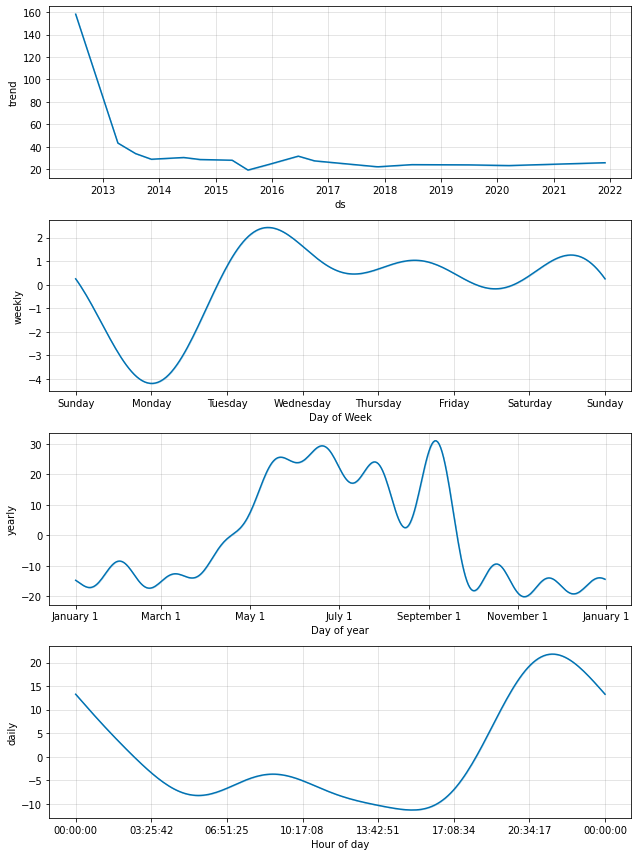

In [35]:
m_future.plot_components(df_forecast)

## Future predictions

Finally, let's make Prophet predict the air quality for the upcoming year 2022. We will use the same previous model as it's already trained with the whole dataset.

In [36]:
future = m_future.make_future_dataframe(periods=365)
future

,ds
0,2012-07-07 16:00:00
1,2012-07-07 17:00:00
2,2012-07-07 18:00:00
3,2012-07-07 19:00:00
4,2012-07-07 20:00:00
...,...
77330,2022-11-26 23:00:00
77331,2022-11-27 23:00:00
77332,2022-11-28 23:00:00
77333,2022-11-29 23:00:00


In [37]:
future_forecast = m_future.predict(future)
future_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2012-07-07 16:00:00,166.088252,100.616679,228.024798
1,2012-07-07 17:00:00,169.080938,110.402130,231.346058
2,2012-07-07 18:00:00,175.428922,112.835165,239.745023
3,2012-07-07 19:00:00,184.068939,119.959958,245.632281
4,2012-07-07 20:00:00,192.285985,128.233785,252.222295
...,...,...,...,...
77330,2022-11-26 23:00:00,31.205012,-33.792470,94.067613
77331,2022-11-27 23:00:00,26.229874,-39.562423,93.034197
77332,2022-11-28 23:00:00,30.500073,-28.208982,93.408196
77333,2022-11-29 23:00:00,31.258706,-32.235190,92.983335


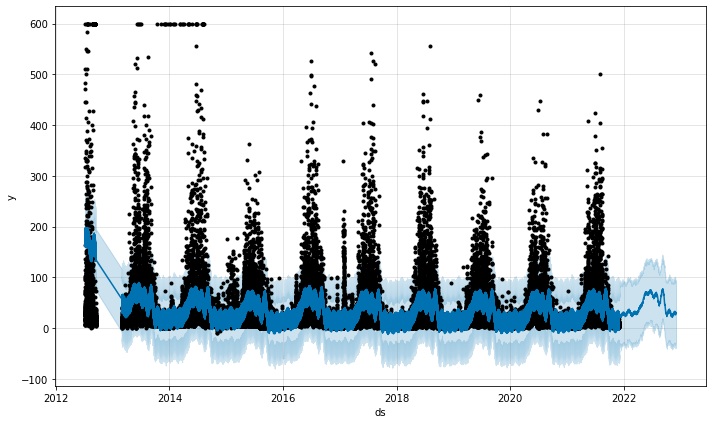

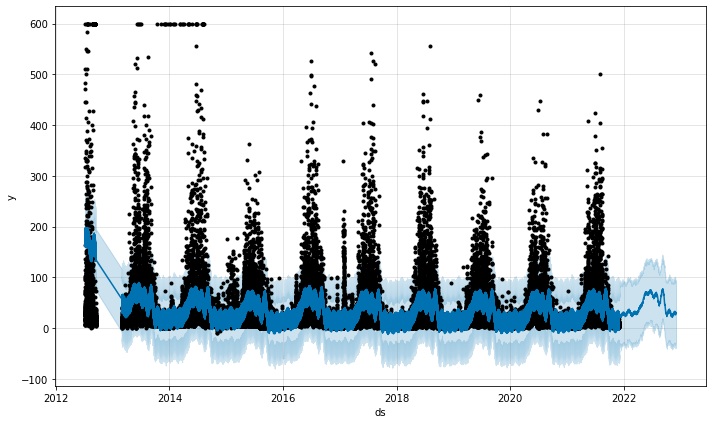

In [38]:
m_future.plot(future_forecast)

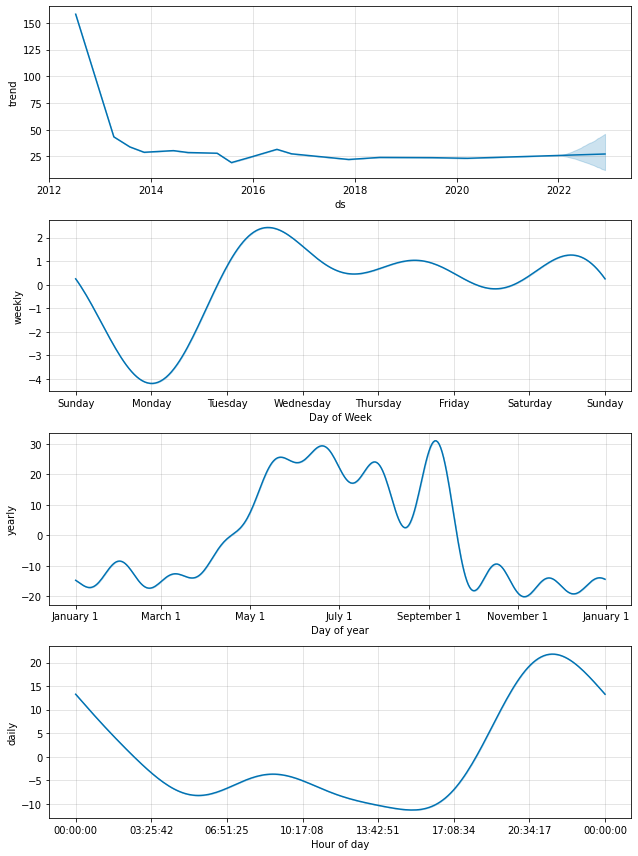

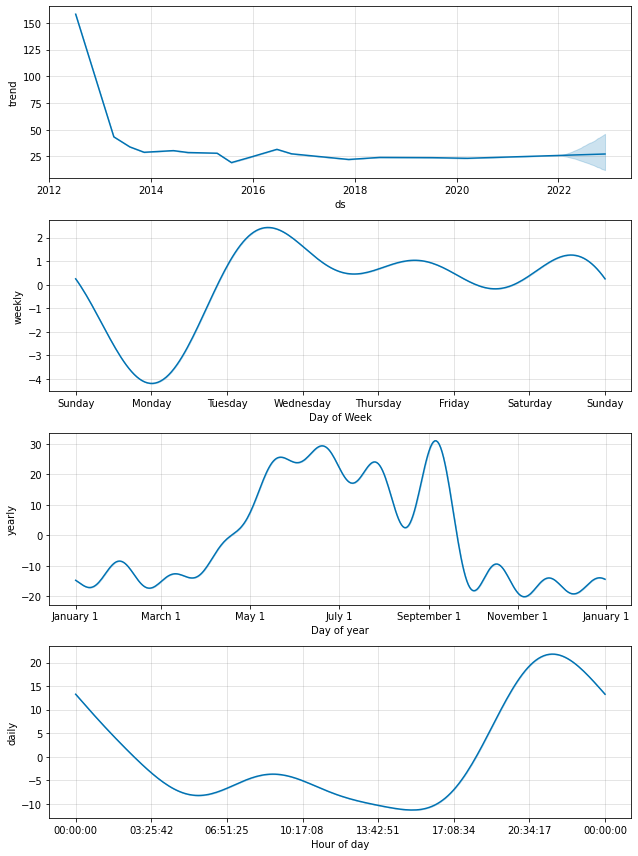

In [39]:
m_future.plot_components(future_forecast)

# Conclussions

As we can see in the graphics, the model was able to identify the seasonality of the values, with peaks between May and September.

The model was also able to predict the values by hour of the day, being the peak around 21 hours.

Finally, values for the year 2022 in general will suffer a little increase compared with the previous years.

# Bonus - Modelling with daily data

We will now create a new model with the average daily values instead of hourly values by calculating the daily average.

In [40]:
df

,ds,y
15,2012-07-07 16:00:00,33.7100
16,2012-07-07 17:00:00,53.9500
17,2012-07-07 18:00:00,96.3999
18,2012-07-07 19:00:00,67.4298
19,2012-07-07 20:00:00,163.2000
...,...,...
82410,2021-11-30 19:00:00,3.0000
82411,2021-11-30 20:00:00,7.0000
82412,2021-11-30 21:00:00,7.0000
82413,2021-11-30 22:00:00,11.0000


## Calculate daily mean

In [41]:
daily_mean = df.set_index('ds').resample('D').mean()
daily_mean['ds'] = daily_mean.index
daily_mean['idx'] = range(daily_mean.shape[0])
daily_mean.set_index('idx', inplace=True)
daily_mean

,y,ds
idx,,
0,212.811212,2012-07-07
1,120.913733,2012-07-08
2,36.074992,2012-07-09
3,28.607624,2012-07-10
4,95.962415,2012-07-11
...,...,...
3429,8.750000,2021-11-26
3430,7.000000,2021-11-27
3431,8.333333,2021-11-28


## Visualize the data

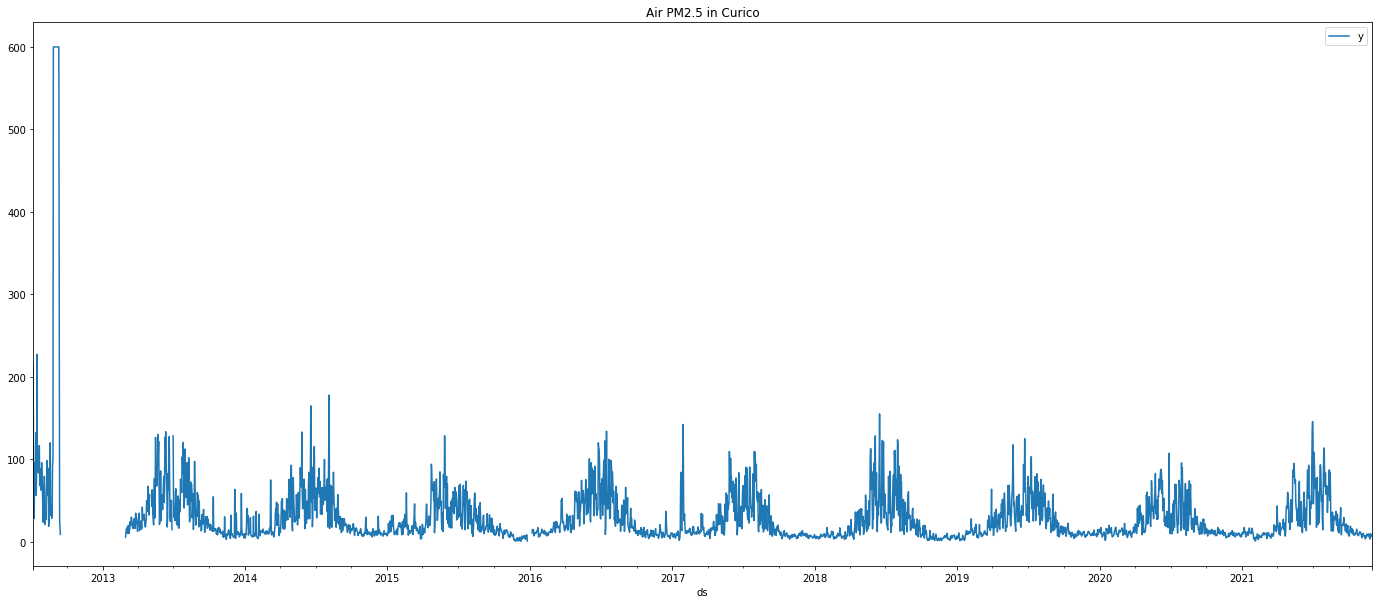

In [42]:
daily_mean.plot(x="ds", y='y', figsize=(24, 10), title="Air PM2.5 in Curico")

## Outliers treatment

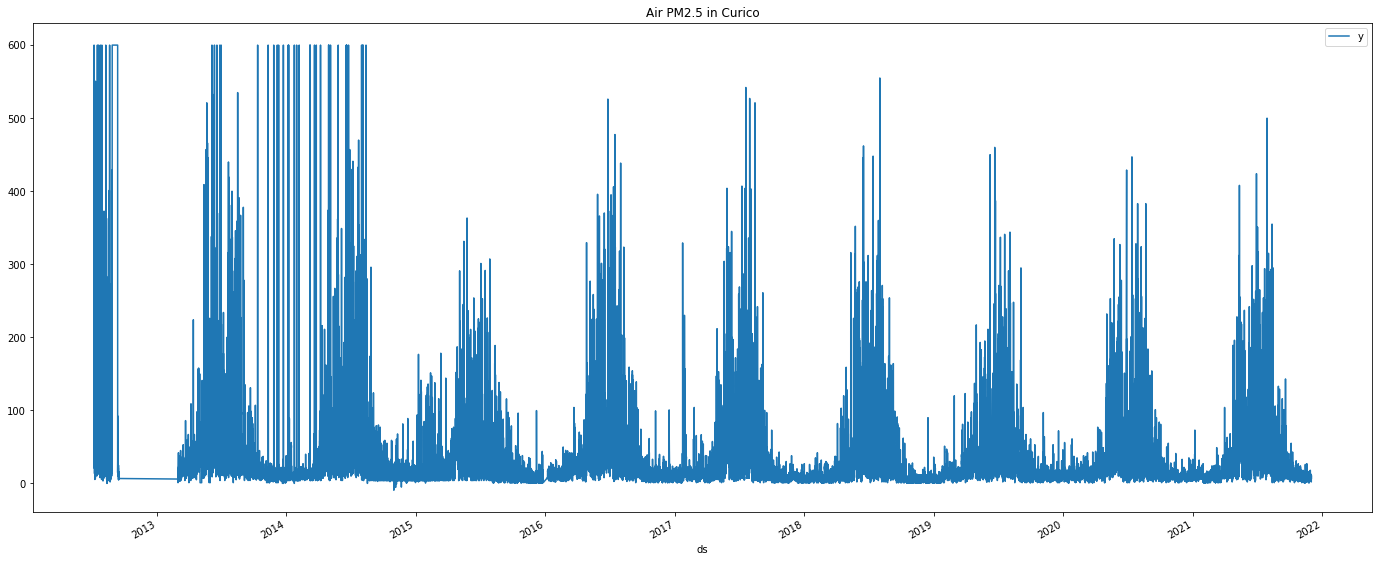

In [43]:
daily_mean['y'].clip(upper=600, inplace=True)

df.plot(x="ds", y='y', figsize=(24, 10), title="Air PM2.5 in Curico")

## Splitting dataset

In [44]:
train_daily = daily_mean[daily_mean['ds'] <= '31-12-2019']
test_daily = daily_mean[daily_mean['ds'] >= '01-01-2020']

In [45]:
train_daily

,y,ds
idx,,
0,212.811212,2012-07-07
1,120.913733,2012-07-08
2,36.074992,2012-07-09
3,28.607624,2012-07-10
4,95.962415,2012-07-11
...,...,...
2729,14.791667,2019-12-27
2730,8.958333,2019-12-28
2731,10.583333,2019-12-29


In [46]:
test_daily

,y,ds
idx,,
2734,13.666667,2020-01-01
2735,12.333333,2020-01-02
2736,12.583333,2020-01-03
2737,10.416667,2020-01-04
2738,17.500000,2020-01-05
...,...,...
3429,8.750000,2021-11-26
3430,7.000000,2021-11-27
3431,8.333333,2021-11-28


## Model fitting

In [47]:
m_daily = Prophet()
m_daily.fit(train_daily)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## Forecasting 2020-2021 air quality

In [48]:
future_daily = m_daily.make_future_dataframe(periods=365 * 2)  # 365 days, two years
future_daily

,ds
0,2012-07-07
1,2012-07-08
2,2012-07-09
3,2012-07-10
4,2012-07-11
...,...
3459,2021-12-26
3460,2021-12-27
3461,2021-12-28
3462,2021-12-29


In [49]:
forecast_daily = m_daily.predict(future_daily)
forecast_daily[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2012-07-07,170.995006,119.751472,225.801209
1,2012-07-08,167.597968,114.565765,217.710734
2,2012-07-09,166.831318,114.002736,217.699659
3,2012-07-10,170.444185,117.058180,223.963294
4,2012-07-11,169.153242,119.546510,218.020075
...,...,...,...,...
3459,2021-12-26,6.749634,-53.576680,61.712682
3460,2021-12-27,6.388239,-52.929815,66.535432
3461,2021-12-28,10.120436,-46.095641,67.225896
3462,2021-12-29,8.677090,-48.177708,68.573142


## Visualizing forecast

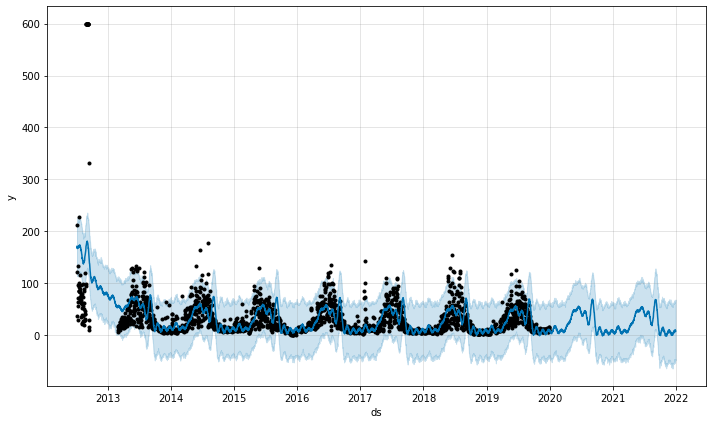

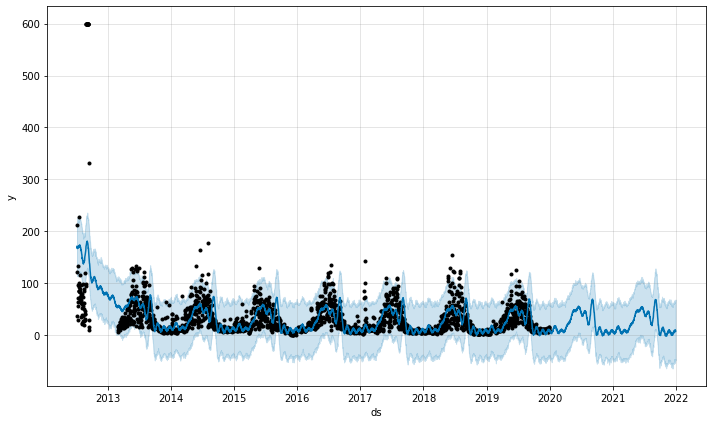

In [50]:
m_daily.plot(forecast_daily)

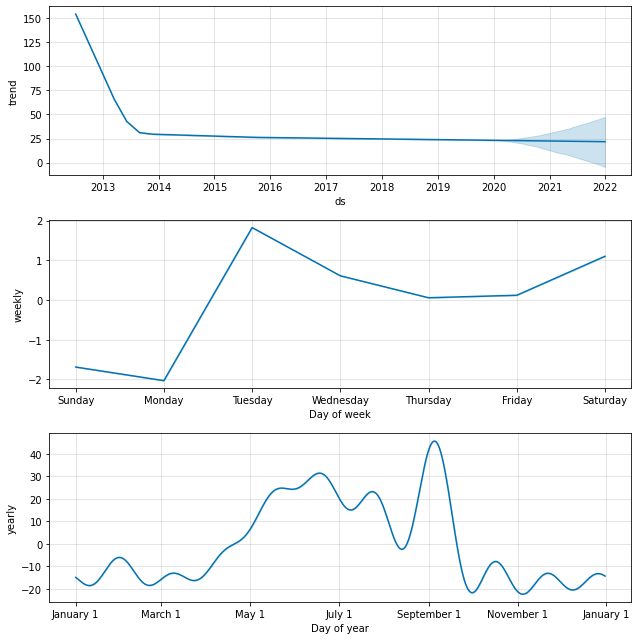

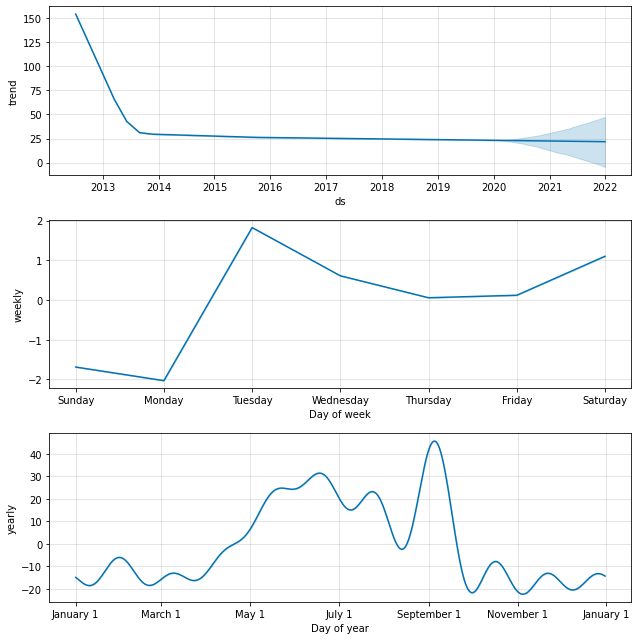

In [51]:
m_daily.plot_components(forecast_daily)

## Evaluating the forecast for the last two years

Firstly we will filter the forecasts to get only the records with dates that we can compare with the testing set.

In [52]:
test_daily

,y,ds
idx,,
2734,13.666667,2020-01-01
2735,12.333333,2020-01-02
2736,12.583333,2020-01-03
2737,10.416667,2020-01-04
2738,17.500000,2020-01-05
...,...,...
3429,8.750000,2021-11-26
3430,7.000000,2021-11-27
3431,8.333333,2021-11-28


In [53]:
forecast_daily['ds']

0      2012-07-07
1      2012-07-08
2      2012-07-09
3      2012-07-10
4      2012-07-11
          ...    
3459   2021-12-26
3460   2021-12-27
3461   2021-12-28
3462   2021-12-29
3463   2021-12-30
Name: ds, Length: 3464, dtype: datetime64[ns]

Selecting the forecasted values that have a comparison entry in the testing set.

In [54]:
filtered_daily_forecast = forecast_daily[forecast_daily.set_index('ds').index.isin(test_daily.set_index('ds').index)]
filtered_daily_forecast = filtered_daily_forecast[['ds', 'yhat']]
filtered_daily_forecast

,ds,yhat
2734,2020-01-01,9.170678
2735,2020-01-02,8.130417
2736,2020-01-03,7.670743
2737,2020-01-04,8.116304
2738,2020-01-05,4.792238
...,...,...
3429,2021-11-26,7.679823
3430,2021-11-27,8.122557
3431,2021-11-28,4.720302
3432,2021-11-29,3.719838


In [55]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

print(f"R2 (test): {r2_score(test_daily['y'], filtered_daily_forecast['yhat'])}")
print(f"MSE (test): {mean_squared_error(test_daily['y'], filtered_daily_forecast['yhat'])}")
print(f"MAE (test): {mean_absolute_error(test_daily['y'], filtered_daily_forecast['yhat'])}")
print(f"MAPE (test): {mean_absolute_percentage_error(test_daily['y'], filtered_daily_forecast['yhat'])}")

R2 (test): 0.27822046562371316
MSE (test): 388.62597414513675
MAE (test): 13.169522698819902
MAPE (test): 0.6603570059846544
